# Verifying Assumptions
By Josh Houlding

Regression takes data represented as variables and a prediction and tries to find the mathematical relation between them. Linear regression and regression analysis are some of the methods through which data is used for predictions, forecasting, inferring relationships, or error reduction. Any type of regression makes assumptions about the data. However, good results will not be obtained if the assumptions are not verified. Therefore, for a successful regression, assumptions must be validated through statistical testing and solutions implemented to tackle any violations if present.

### Task 1
Access the repository and use the dataset provided by the instructor.

<hr>

<b>Dataset Kaggle page:</b> https://www.kaggle.com/datasets/mercheovejero/theory-of-mind-in-remitted-bipolar-disorder/data <br>
<b>Study linked by dataset:</b> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222112

In [154]:
# Import basic libraries
import pandas as pd
import numpy as np 

# Import modeling libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import testing libraries
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [155]:
# Load and preview dataset
df = pd.read_csv("Database MiniPONS.csv", sep=";")
df.head()

Group   Type  Age  Right_answers  Audio_prosody  Combined_channel  \
0  Bipolar   BD I   47             40              9                11   
1  Bipolar   BD I   49             49             13                13   
2  Bipolar   BD I   45             43              9                11   
3  Bipolar   BD I   53             44             10                10   
4  Bipolar  BD II   50             50             14                13   

   Face_video  Body_video  Positive_valence  Negative_valence  Dominant  \
0           9          11                18                22        23   
1          11          12                24                25        24   
2          13          10                21                22        24   
3          12          12                25                19        24   
4          11          12                23                27        23   

   Submissive  
0          17  
1          25  
2          19  
3          20  
4          27

In [156]:
# Check dataset size
print("The dataset has", len(df), "entries.")

The dataset has 277 entries.


In [157]:
# Make all columns lowercase for ease of typing
df.columns = df.columns.str.lower()
print("New column names:", df.columns)
print()

# Set "group" values to lowercase
df["group"] = df["group"].str.lower()

# Set "type" values to "typeI", "typeII", "control" and "ud"
df["type"] = np.where(df["type"] == "BD I", "typeI", df["type"])
df["type"] = np.where(df["type"] == "BD II", "typeII", df["type"])
df["type"] = np.where(df["type"] == "Control", "control", df["type"])
df["type"] = np.where(df["type"] == "UD", "ud", df["type"])
print("Unique values of 'type':", df["type"].unique())

New column names: Index(['group', 'type', 'age', 'right_answers', 'audio_prosody',
       'combined_channel', 'face_video', 'body_video', 'positive_valence',
       'negative_valence', 'dominant', 'submissive'],
      dtype='object')

Unique values of 'type': ['typeI' 'typeII' 'control' 'ud']


### Task 2
Describe a predictive model you could build using this dataset and present it, including the analysis of the residuals.

<hr>

In [158]:
# Show data types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   group             277 non-null    object
 1   type              277 non-null    object
 2   age               277 non-null    int64 
 3   right_answers     277 non-null    int64 
 4   audio_prosody     277 non-null    int64 
 5   combined_channel  277 non-null    int64 
 6   face_video        277 non-null    int64 
 7   body_video        277 non-null    int64 
 8   positive_valence  277 non-null    int64 
 9   negative_valence  277 non-null    int64 
 10  dominant          277 non-null    int64 
 11  submissive        277 non-null    int64 
dtypes: int64(10), object(2)
memory usage: 26.1+ KB


We see that the dataset is mostly comprised of numeric variables, with 2 variables, `group` and `type` being exceptions. To build a predictive model, we must convert these 2 variables to numeric using one-hot encoding (dummy variables). 

In [159]:
# Make backup of non-dummified dataframe
df_backup = df.copy()

# Encode "group" and "type" as dummy variables
df = pd.get_dummies(df, columns=["group", "type"])

Now that we have our dummy variables, we will apply min-max normalization to ensure all variables are on the same scale. 

In [160]:
# Normalize variables
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Show new normalized dataframe
df.head()

age  right_answers  audio_prosody  combined_channel  face_video  \
0  0.456140       0.400000       0.461538               0.5    0.142857   
1  0.491228       0.700000       0.769231               0.7    0.428571   
2  0.421053       0.500000       0.461538               0.5    0.714286   
3  0.561404       0.533333       0.538462               0.4    0.571429   
4  0.508772       0.733333       0.846154               0.7    0.428571   

   body_video  positive_valence  negative_valence  dominant  submissive  \
0    0.545455          0.294118              0.60  0.578947    0.235294   
1    0.636364          0.647059              0.75  0.631579    0.705882   
2    0.454545          0.470588              0.60  0.631579    0.352941   
3    0.636364          0.705882              0.45  0.631579    0.411765   
4    0.636364          0.588235              0.85  0.578947    0.823529   

   group_bipolar  group_control  group_ud  type_control  type_typeI  \
0            1.0            0.0       0.0           0.0         1.0   
1            1.0            0.0       0.0           0.0         1.0   
2            1.0            0.0       0.0           0.0         1.0   
3            1.0            0.0       0.0           0.0         1.0   
4            1.0            0.0       0.0           0.0         0.0   

   type_typeII  type_ud  
0          0.0      0.0  
1          0.0      0.0  
2          0.0      0.0  
3          0.0      0.0  
4          1.0      0.0

In [161]:
# Check number of columns
len(df.columns)

17

The data is now ready for modeling. 

In [162]:
# Get features and target from dataframe
x = df[["age", "audio_prosody", "combined_channel", "face_video", "body_video", "positive_valence", "negative_valence", "dominant", "submissive", "group_bipolar", "group_control", "group_ud", "type_control", "type_typeI", "type_typeII", "type_ud"]]
y = df["right_answers"]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create the model
model = LinearRegression()

# Train the model
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model coefficients:", model.coef_)
print("Mean squared error (MSE):", mse)
print("R^2:", r2)

Model coefficients: [ 2.20343642e-16  1.87384153e-01  1.44141656e-01  1.00899159e-01
  1.58555822e-01  1.56129054e-01  1.83681240e-01  1.84967009e-01
  1.65496797e-01  1.24900090e-16 -2.77555756e-17  2.77555756e-17
 -2.77555756e-17  1.11022302e-16 -5.20417043e-17  2.77555756e-17]
Mean squared error (MSE): 2.5422275265911513e-32
R^2: 1.0


<b>Residual analysis</b>

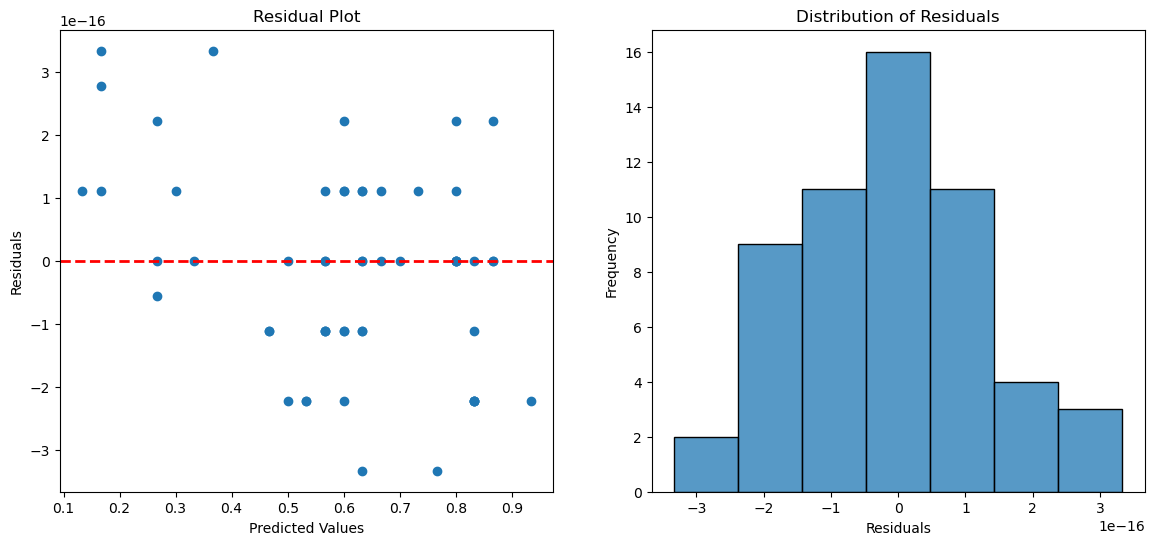

In [163]:
# Calculate residuals
residuals = y_test - y_pred

# Set up plot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Plot the residual plot
axes[0].scatter(y_pred, residuals)
axes[0].set_title("Residual Plot")
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Residuals")
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)

# Plot the histogram of residuals
sns.histplot(residuals, ax=axes[1])
axes[1].set_title("Distribution of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")

plt.show()

The residuals appear to exhibit random scatter and are normally distributed, implying no violations to the assumptions of linear regression. 

### Task 3
Verify the assumptions of the linear regression using plots. Explain each test, comment on the code, and interpret the test result for: <br><br>
<b>a) Linear relationship:</b> Each predictor variable $x_{i}$ and the outcome variable $y$. Use the plot function and which=1. <br>
<b>b) Independence:</b> The residuals are independent. Use the Durbin-Watson test. <br>
<b>c) Homoscedasticity:</b> The residuals have constant variance at every level of x. Use plot function and which=3; <br> 
<b>d) Normality:</b> The residuals of the model are normally distributed. Use the plot function and which=2. <hr>

<b>Verifying the linear relationship</b><br>
Each predictor variable $x_{i}$ and the outcome variable $y$. Use the plot function and which=1.

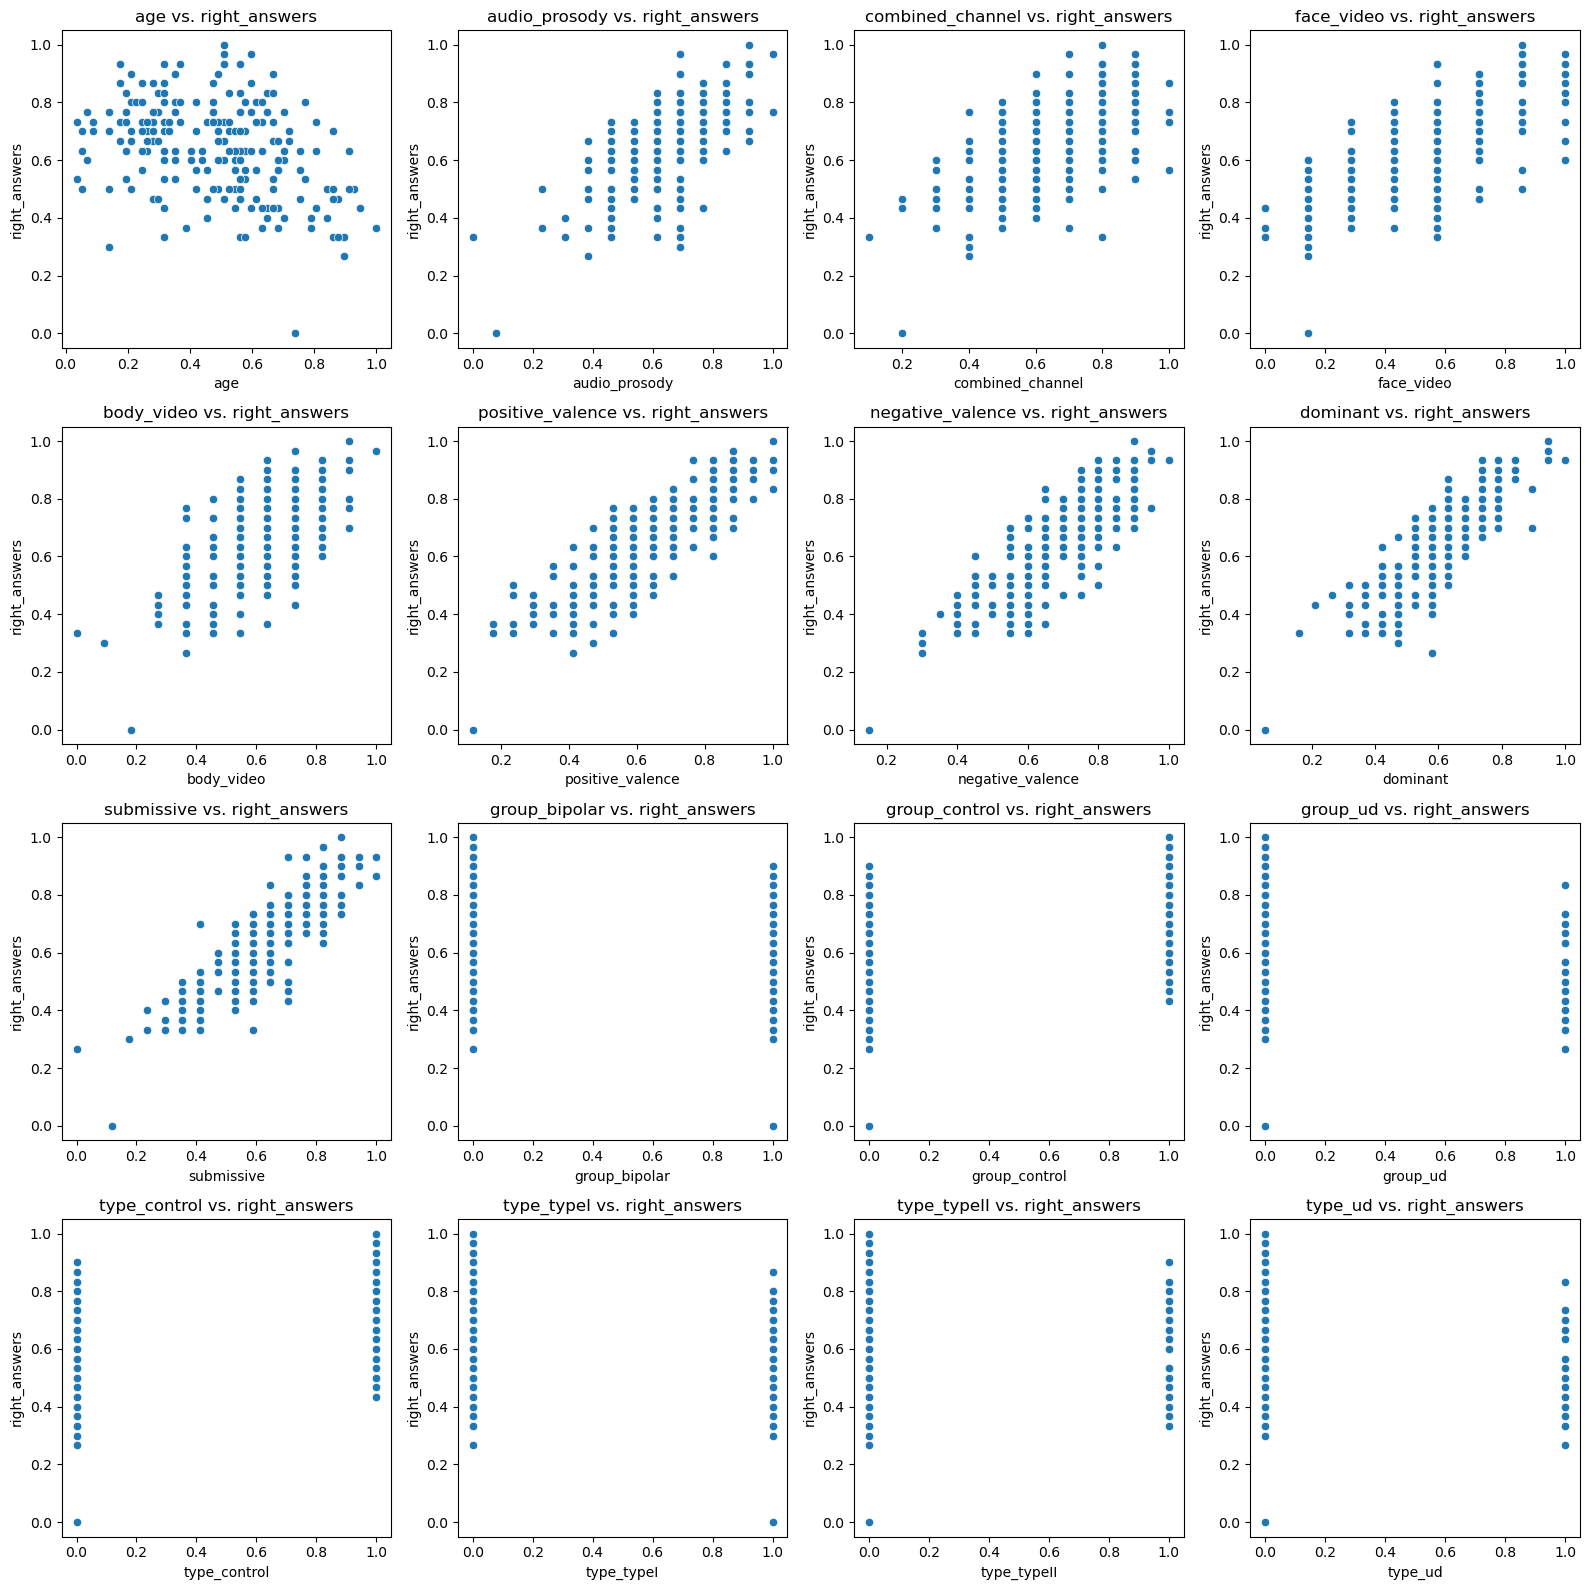

In [164]:
# Get data for plotting
data_for_plot = pd.concat([x_train, y_train], axis=1)

# Create scatterplots for each predictor variable against the outcome variable
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for i, column in enumerate(x_train.columns):
    row, col = divmod(i, 4)
    sns.scatterplot(x=column, y='right_answers', data=data_for_plot, ax=axes[row, col])
    axes[row, col].set_title(f"{column} vs. right_answers")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

We see that the first 9 predictor variables all have approximately linear relationships with the response variable `right_answers`. Thus, the assumption of linearity is not violated. The last 7 are dummy variables and thus can only have values of 0 or 1. 

<b>Verifying independence</b> <br>
Independence: The residuals are independent. Use the Durbin-Watson test. <br>

In [165]:
# Perform Durbin-Watson test for independence of residuals
durbin_watson_stat = sm.stats.durbin_watson(residuals)
print("Durbin-Watson Statistic:", durbin_watson_stat)

Durbin-Watson Statistic: 2.121212121212121


According to <a src="https://www.investopedia.com/terms/d/durbin-watson-statistic.asp#:~:text=The%20Durbin%20Watson%20%28DW%29%20statistic%20is%20a%20test,there%20is%20no%20autocorrelation%20detected%20in%20the%20sample.">Investopedia</a>, the Durbin-Watson stat will always be in the range [0, 4], with a value close to 2 indicating minimal autocorrelation. This is what our test reveals, so we conclude that there is negligible autocorrelation present in the model. 

<b>Verifying homoscedasticity</b> <br>
Homoscedasticity: The residuals have constant variance at every level of x. Use plot function and which=3; <br> 

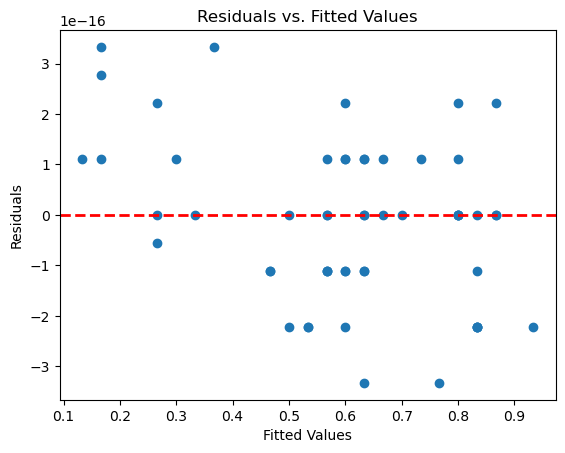

In [166]:
# View scatterplot of residuals
plt.scatter(y_pred, residuals)
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
plt.show()

We see what appears to be random scatter, so homoscedasticity is not violated.

<b>Verifying normality</b> <br>
Normality: The residuals of the model are normally distributed. Use the plot function and which=2.

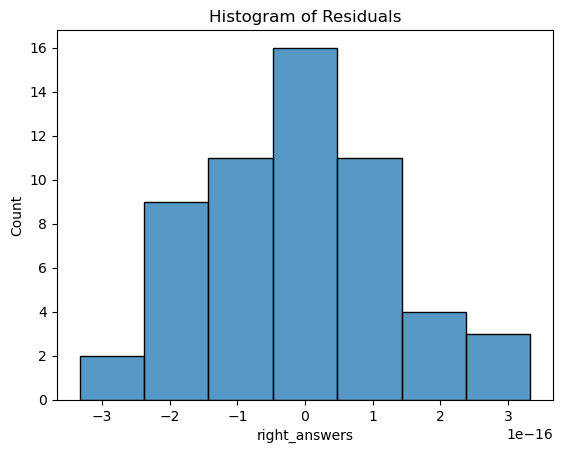

In [167]:
# Plot residuals in histogram
sns.histplot(residuals)
plt.title("Histogram of Residuals")
plt.show()

We see that the residuals are normally distributed. With that, all assumptions of linear regression have been verified successfully. 

### Task 4
Verify the assumption of homoscedasticity computationally using the Non-Constant Variance Score (NCV) test (ncvTest function). Explain the test, the R code, and interpret the test results. Explain the relationship between NCV and the Durbin-Watson test.

<hr>

<b>Note:</b> I ran into trouble installing the `lmtest` package that contains the `ncvTest` function, so I opted for installation of the `het_breuschpagan` package, which is a part of `statsmodels`. The Breusch-Pagan test is equivalent to the NCV test for homoscedasticity, so results should be identical. 

<b>NCV test criteria</b><br>
* $H_0$: The residuals exhibit homoscedasticity (constant variance at every level of x). 
* $H_a$: The residuals exhibit heteroscedasticity (non-constant variance). 
* $\alpha = 0.05.$

In [168]:
# Perform NCV (Breusch-Pagan) test on residuals
ncv_test_result = het_breuschpagan(residuals, sm.add_constant(x_test))
test_stat, p_value, _, _ = ncv_test_result
print(f"NCV test statistic: {test_stat}")
print(f"P-value: {p_value}")

NCV test statistic: 5.46132083035753
P-value: 0.9929406203891832


We get a P-value far greater than $\alpha = 0.05$, so we fail to reject $H_0$ and conclude that the residuals exhibit homoscedasticity. 

The NCV and Durbin-Watson tests are both diagnostic tools used to verify the homoscedasticity of residuals in linear regression models, but they differ in their purpose. 
* <b>NCV test:</b> Tests for homoscedasticity directly by checking if the residuals have constant variance at every level of x. A significant result indicates that heteroscedasticity (non-constant variance) may be present. 
* <b>Durbin-Watson test:</b> Tests for homoscedasticity indirectly through checking for autocorrelation (patterns between serial residuals). A Durbin-Watson score close to 2 suggests no significant autocorrelation, while a value far away from 2 indicates that positive or negative autocorrelation may be present. 

<hr>

### Task 5
Assess the presence of significant outliers and explain their potential impact. Use the plot function and which=5, and the Cook distance.

In [169]:
# Refit model with statsmodels
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

# Get Cook's distance for each observation
influence = OLSInfluence(model)
cook_distance = influence.cooks_distance[0]

# Find outliers (4 / n is the typical threshold for identifying influential observations)
outlier_threshold = 4 / len(cook_distance)
influential_observations = cook_distance[cook_distance > outlier_threshold]
influential_observations

95    0.016724
dtype: float64

In [170]:
# Show the observation at index 95
outlier = df.iloc[95]
outlier.to_frame().transpose()

age  right_answers  audio_prosody  combined_channel  face_video  \
95  0.315789       0.333333            0.0               0.8    0.571429   

    body_video  positive_valence  negative_valence  dominant  submissive  \
95    0.363636          0.411765               0.4  0.421053    0.294118   

    group_bipolar  group_control  group_ud  type_control  type_typeI  \
95            1.0            0.0       0.0           0.0         1.0   

    type_typeII  type_ud  
95          0.0      0.0

When using the Cook distance for each observation, we find that the one at index 95 in the dataframe is the only potential outlier. This observation could significantly affect the regression intercept and coefficients, leading to a model that is less accurate than we would like. 

### Task 6
Explain how you would mitigate the impact of the outlier. Then, implement measures to mitigate the impact of outliers (e.g., removal or other transformations of the data).

<hr>

Because there is only one outlier, applying a large-scale transformation to the data is unnecessary. Thus, the most straightforward approach would be to simply remove it. 

In [171]:
# Remove the observation at index 95
df = df.drop(index=95)
df.reset_index(drop=True, inplace=True)
df.head()

age  right_answers  audio_prosody  combined_channel  face_video  \
0  0.456140       0.400000       0.461538               0.5    0.142857   
1  0.491228       0.700000       0.769231               0.7    0.428571   
2  0.421053       0.500000       0.461538               0.5    0.714286   
3  0.561404       0.533333       0.538462               0.4    0.571429   
4  0.508772       0.733333       0.846154               0.7    0.428571   

   body_video  positive_valence  negative_valence  dominant  submissive  \
0    0.545455          0.294118              0.60  0.578947    0.235294   
1    0.636364          0.647059              0.75  0.631579    0.705882   
2    0.454545          0.470588              0.60  0.631579    0.352941   
3    0.636364          0.705882              0.45  0.631579    0.411765   
4    0.636364          0.588235              0.85  0.578947    0.823529   

   group_bipolar  group_control  group_ud  type_control  type_typeI  \
0            1.0            0.0       0.0           0.0         1.0   
1            1.0            0.0       0.0           0.0         1.0   
2            1.0            0.0       0.0           0.0         1.0   
3            1.0            0.0       0.0           0.0         1.0   
4            1.0            0.0       0.0           0.0         0.0   

   type_typeII  type_ud  
0          0.0      0.0  
1          0.0      0.0  
2          0.0      0.0  
3          0.0      0.0  
4          1.0      0.0

### Task 7
Discuss what other tests/transformations you could use if there are no outliers. Could a log transformation for reducing skewness be used? Explain. <hr>

Log transformations are indeed a common way to reduce skewness in a distribution. However, this isn't necessary unless significant skewness is present in some or all of the variables. Let's check: 

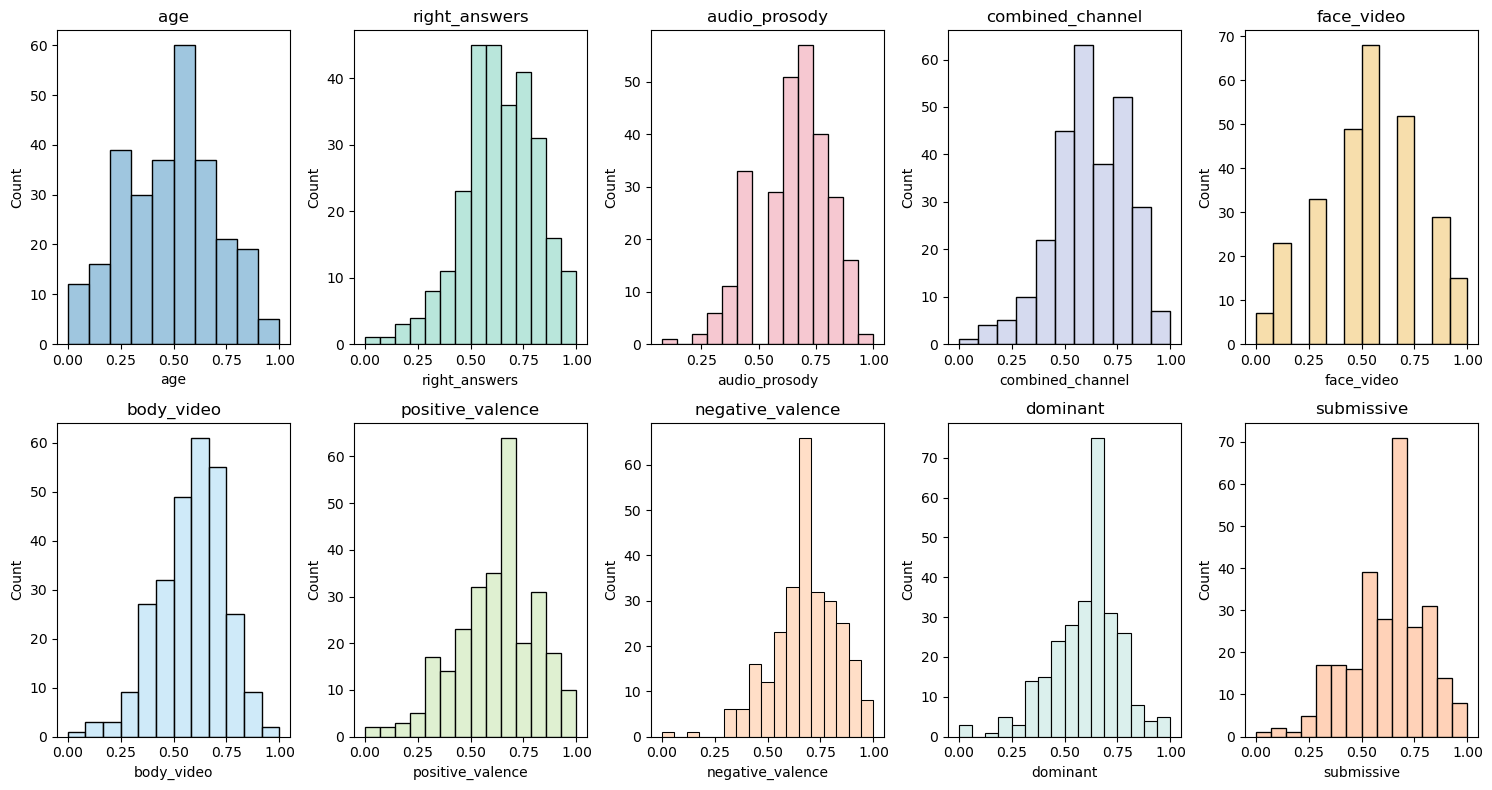

In [172]:
# Get subset of variables that aren't dummies
non_dummy_variables = df.columns[:10]

# Set up plot grid
fig, axes = plt.subplots(2, 5, figsize=(15,8))
axes = axes.flatten()

# Define colors for histograms
colors = ["#7FB3D5", "#A2DED0", "#F4B6C2", "#C7CEEA", "#F5D491", "#C0E4F7", "#D5ECC2", "#FFD3B5", "#D0ECE7", "#FFC3A0"]

# Plot histograms for each variable
for i, column in enumerate(non_dummy_variables): 
    sns.histplot(df[column], ax=axes[i], color=colors[i], kde=False)
    axes[i].set_title(column)
    
# Show plots
plt.tight_layout()
plt.show()

Some of the non-dummy variables in the data have a slight skewness to them, but most follow a near-standard normal distribution, so no log transformations are needed. The data as-is should be perfectly adequate for modeling and answering questions related to the study. 

### Task 8
Repeat steps 4-5, using the "cleaner" dataset. <hr>

We will repeat tasks 4 and 5 with the new dataset that does not contain the outlier we found earlier. 

<b>NCV test criteria</b><br>
* $H_0$: The residuals exhibit homoscedasticity (constant variance at every level of x). 
* $H_a$: The residuals exhibit heteroscedasticity (non-constant variance). 
* $\alpha = 0.05.$

In [173]:
# Get features and target from dataframe
x = df[["age", "audio_prosody", "combined_channel", "face_video", "body_video", "positive_valence", "negative_valence", "dominant", "submissive", "group_bipolar", "group_control", "group_ud", "type_control", "type_typeI", "type_typeII", "type_ud"]]
y = df["right_answers"]

# Retrain model on "cleaner" data
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

# Calculate residuals
residuals = model.resid

# Perform NCV (Breusch-Pagan) test on residuals
ncv_test_result = het_breuschpagan(residuals, x)
test_stat, p_value, _, _ = ncv_test_result
print(f"NCV test statistic: {test_stat}")
print(f"P-value: {p_value}")

NCV test statistic: 187.62116849018358
P-value: 2.48427045942202e-31


Since $P < \alpha$, we reject $H_0$ and conclude that heteroscedasticity (non-constant variance) is present in the residuals.

In response, there are several options available for dealing with heteroscedasticity. These include log and Box-Cox transformations, which can be applied either to the dependent variable or to a subset of independent variables, and weighted least squares (WLS) regression, which gives each observation a weight based on the inverse of its variance, thus prioritizing observations with smaller variances. 

In [174]:
# Get Cook's distance for each observation
influence = OLSInfluence(model)
cook_distance = influence.cooks_distance[0]

# Find outliers
outlier_threshold = 4 / len(cook_distance)
influential_observations = cook_distance[cook_distance > outlier_threshold]
influential_observations

103    0.017754
257    0.016320
dtype: float64

This time we uncover 2 influential observations in the new model, which could both have a considerable impact on the model overall. If we wanted to, we could remove these as well to improve the model's accuracy even more. 

### Task 9
Test collinearity using the Variance Inflation Factor. Use the vif function in R or Python. <hr>

In [175]:
# Get predictor variables only
x = df.drop(columns={"right_answers"})
vif_data = pd.DataFrame()
vif_data["Variable"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_data.transpose()

C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0              1                 2           3           4   \
Variable       age  audio_prosody  combined_channel  face_video  body_video   
VIF       1.463103            inf               inf         inf         inf   

                        5                 6         7           8   \
Variable  positive_valence  negative_valence  dominant  submissive   
VIF                    inf               inf       inf         inf   

                     9              10        11            12          13  \
Variable  group_bipolar  group_control  group_ud  type_control  type_typeI   
VIF                 inf            inf       inf           inf         inf   

                   14       15  
Variable  type_typeII  type_ud  
VIF               inf      inf

We see problems with perfect collinearity in the model, which prevent the VIF from being calculated for all the predictor variables. We can see which variables are perfectly correlated using a correlation matrix. 

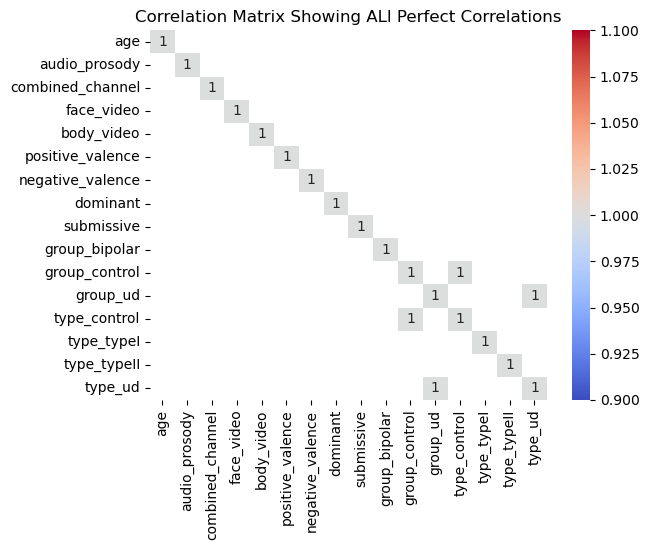

In [176]:
corr_matrix = x.corr()
mask = (corr_matrix == 1)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=~mask)
plt.title("Correlation Matrix Showing ALl Perfect Correlations")
plt.show()

We see that variable pairs such as `group_control` and `type_control`, and `group_ud` and `type_ud`, are perfectly correlated, suggesting that the collinearity problem is entirely down to several dummy variables. Let's remove those and retry the VIF calculations. 

In [177]:
# Remove "group_control" and "group_ud"
x = x.drop(columns={"group_control", "group_ud"})

In [178]:
# Calculate VIF using alternate method
vif_data = pd.DataFrame()
vif_data["Variable"] = x.columns
x_with_constant = sm.add_constant(x)
model = sm.OLS(y, x_with_constant).fit()
vif_data["VIF"] = 1 / (1 - model.rsquared)
vif_data.transpose()

C:\Users\jdh10\AppData\Local\Temp\ipykernel_4380\2601455026.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  vif_data["VIF"] = 1 / (1 - model.rsquared)


0              1                 2           3           4   \
Variable  age  audio_prosody  combined_channel  face_video  body_video   
VIF       inf            inf               inf         inf         inf   

                        5                 6         7           8   \
Variable  positive_valence  negative_valence  dominant  submissive   
VIF                    inf               inf       inf         inf   

                     9             10          11           12       13  
Variable  group_bipolar  type_control  type_typeI  type_typeII  type_ud  
VIF                 inf           inf         inf          inf      inf

It appears that collinearity cannot properly be addressed to calculate the VIF values for each predictor variable. Removing perfectly-correlated variables did not resolve the issue, indicating a deeper problem with collinearity in the data. This will severely restrict the utility of the model. 

### Task 10
Assess the overall validity of the regression model and present your final assessment regarding its readiness and suitability for making predictions. <hr>

The data the regression model was trained on is adequate, with no missing or nonsensical values, all categorical variables coded into dummy variables, and properly normalized. The model trained earlier was also determined not to violate any of the assumptions of linear regression. However, the collinearity issues encountered earlier will hamper its utility for making predictions. 

### Task 11
Given your analysis, describe the recommendations you would make to a researcher intent on using this data in a multiple linear regression model.

To use the original dataset in a multiple linear regression model, I would make the following recommendations: 
1. Set categorical variable values and column names to lowercase phrases separated with underscores, as this makes future dummy variable column names more accessible. 
2. Ensure all data types are sensible. 
3. Encode the two categorical variables as dummies so they can be used in a regression model. 
4. Apply min-max normalization to the data so every variable is on the same [0, 1] scale. 
5. Train the model, and ensure that common assumptions of linear regression are not violated. 

### References
Theory of mind in remitted bipolar disorder. (2019, September 12). Kaggle. https://www.kaggle.com/datasets/mercheovejero/theory-of-mind-in-remitted-bipolar-disorder/data

Espinós, U., Fernández-Abascal, E. G., & Ovejero, M. (2019). Theory of mind in remitted bipolar disorder: Interpersonal accuracy in recognition of dynamic nonverbal signals. PLOS ONE, 14(9), e0222112. https://doi.org/10.1371/journal.pone.0222112

ChatGPT. (n.d.). https://chat.openai.com/